In [1]:
%load_ext dotenv
%dotenv -o

import os
os.environ["POLYGON_DATA_DIR"]

'/media/mirror/files.polygon.io'

In [2]:
from zipline_polygon_bundle.config import PolygonConfig
from zipline_polygon_bundle import date_to_path, trades_schema, cast_trades, custom_aggs_schema, custom_aggs_partitioning, generate_csv_trades_tables, trades_to_custom_aggs
from zipline_polygon_bundle import get_custom_aggs_dates

from typing import Iterator, Tuple

import pandas as pd
import plotly.graph_objs as go

import pyarrow as pa
from pyarrow import dataset as pa_ds
from pyarrow import compute as pa_compute
from pyarrow import compute as pc
from pyarrow import parquet as pa_parquet

from fsspec.implementations.arrow import ArrowFSWrapper

import os

import datetime
import pandas_market_calendars
import numpy as np

import resource

from itables import show

In [3]:
if not "CUSTOM_ASSET_FILES_DIR" in os.environ:
    os.environ["CUSTOM_ASSET_FILES_DIR"]= "/home/jovyan/data"

config = PolygonConfig(
    environ=os.environ,
    calendar_name="NYSE",
    start_date="2018-01-01",
    end_date="2023-12-31",
    agg_time="1min",
)

pd.set_option('display.width', 250)

print(f"{config.minute_aggs_dir=}")
print(f"{config.trades_dir=}")
print(f"{config.custom_aggs_dir=}")
print(f"{config.aggs_dir=}")
print(f"{config.by_ticker_dir=}")

config.minute_aggs_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/minute_aggs_v1'
config.trades_dir='/media/mirror/files.polygon.io/flatfiles/us_stocks_sip/trades_v1'
config.custom_aggs_dir='/home/jovyan/data/60sec_aggs'
config.aggs_dir='/home/jovyan/data/60sec_aggs'
config.by_ticker_dir='/home/jovyan/data/60sec_aggs_by_ticker'


In [8]:
def label_ticker_session(df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    # df.info()
    df = df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


# def label_ticker_day_aggs(df: pd.DataFrame, sessions: pd.Series):
#     pre_df = label_ticker_session(df, start=sessions['pre'], end=sessions['market_open'] - pd.Timedelta(seconds=60))
#     market_df = label_ticker_session(df, start=sessions['market_open'], end=sessions['market_close'] - pd.Timedelta(seconds=60))
#     post_df = label_ticker_session(df, start=sessions['market_close'], end=sessions['post'] - pd.Timedelta(seconds=60))
#     return pd.concat([pre_df, market_df, post_df])


def label_custom_aggs_for_date(sessions, aggs_df):
    def label_custom_aggs(df: pd.DataFrame):
        # ticker = df.iloc[0]['ticker']
        # df = df.drop(columns=['ticker'])
        df = df.set_index('window_start').sort_index()
        # df = df.set_index('window_start')
        # df.info()
        return label_ticker_session(df, start=sessions['pre'], end=sessions['market_open'] - pd.Timedelta(seconds=60))
    
    aggs_df.set_index('ticker', inplace=True)
    aggs_df.sort_index(inplace=True)
    labeled_aggs_df = aggs_df.groupby('ticker').apply(label_custom_aggs)
    labeled_aggs_df.info()
    print(labeled_aggs_df)
    return labeled_aggs_df


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post",
                                 tz='US/Eastern')
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        print(f"{date=} {sessions=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        filter_expr = (pc.field('year') == date.year) & (pc.field('month') == date.month) & (pc.field('date') == date.to_pydatetime().date())
        print(f"{filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=filter_expr):
            labeled_aggs_dfs.append(label_custom_aggs_for_date(sessions, fragment.to_table().to_pandas()))

    return labeled_aggs_dfs

In [21]:
def label_ticker_session(df: pd.DataFrame):
    # df.info()
    df = df.set_index('window_start').sort_index()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


def label_custom_aggs_for_date(df: pd.DataFrame):
    # df.set_index('ticker', inplace=True)
    # df.sort_index(inplace=True)
    # df = df.set_index('ticker').sort_index()
    return df.set_index('ticker').sort_index().groupby('ticker').apply(label_ticker_session)


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post")
    labeled_aggs_dfs = []
    for date, sessions in schedule.iterrows():
        # print(f"{date=} {sessions=}")
        start_dt = sessions['pre']
        end_dt = sessions['market_open']
        print(f"{date=} {start_dt=} {end_dt=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        date_filter_expr = ((pc.field('year') == date.year)
                       & (pc.field('month') == date.month)
                       & (pc.field('date') == date.to_pydatetime().date()))
        print(f"{date_filter_expr=}")
        for fragment in aggs_ds.get_fragments(filter=date_filter_expr):
            session_filter = ((pc.field('window_start') >= start_dt)
                              & (pc.field('window_start') < end_dt))
            # Sorting table doesn't seem to avoid needing to sort the df.  Maybe use_threads=False on to_pandas would help?
            # table = fragment.to_table(filter=session_filter).sort_by([('ticker', 'ascending'), ('window_start', 'descending')])
            table = fragment.to_table(filter=session_filter)
            labeled_aggs_dfs.append(label_custom_aggs_for_date(table.to_pandas()))

    return labeled_aggs_dfs

In [22]:
config.start_date = '2024-12-05'
config.end_date = '2024-12-05'
labeled_aggs_dfs = label_custom_aggs_ds(config)
labeled_aggs_dfs

date=Timestamp('2024-12-05 00:00:00') start_dt=Timestamp('2024-12-05 09:00:00+0000', tz='UTC') end_dt=Timestamp('2024-12-05 14:30:00+0000', tz='UTC')
date_filter_expr=<pyarrow.compute.Expression (((year == 2024) and (month == 12)) and (date == 2024-12-05))>


[                                    open    high     low   close  volume  transactions  gain_from_open  fwd_1h_min_low  fwd_1h_max_close  gain_1h  loss_1h
 ticker                                                                                                                                                    
 A      2024-12-05 09:32:00+00:00  140.15  140.19  140.15  140.19     4.0           2.0        0.000000          140.15            140.19      NaN      NaN
        2024-12-05 09:33:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-05 09:34:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-05 09:35:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN             NaN               NaN      NaN      NaN
        2024-12-05 09:36:00+00:00     NaN     NaN     NaN     Na

In [23]:
len(labeled_aggs_dfs)

1

In [24]:
labeled_aggs_dfs[0].info()
labeled_aggs_dfs[0]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1135582 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZYXI', Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              159913 non-null  float64
 1   high              159913 non-null  float64
 2   low               159913 non-null  float64
 3   close             159913 non-null  float64
 4   volume            159913 non-null  float64
 5   transactions      159913 non-null  float64
 6   gain_from_open    159913 non-null  float64
 7   fwd_1h_min_low    933044 non-null  float64
 8   fwd_1h_max_close  933044 non-null  float64
 9   gain_1h           153782 non-null  float64
 10  loss_1h           153782 non-null  float64
dtypes: float64(11)
memory usage: 99.8+ MB


open    high     low   close  volume  transactions  gain_from_open  fwd_1h_min_low  fwd_1h_max_close  gain_1h  loss_1h
ticker                                                                                                                                                    
A      2024-12-05 09:32:00+00:00  140.15  140.19  140.15  140.19     4.0           2.0        0.000000          140.15            140.19      NaN      NaN
       2024-12-05 09:33:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:34:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:35:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN             NaN               NaN      NaN      NaN
       2024-12-05 09:36:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN             NaN               NaN      NaN      NaN
...                                  ...     ...     ...     ...     ...           ...             ...             ...               ...      ...      ...
ZYXI   2024-12-05 14:25:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:26:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:27:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN            8.05              8.05      NaN      NaN
       2024-12-05 14:28:00+00:00     NaN     NaN     NaN     NaN     NaN           NaN             NaN            8.05              8.05      0.0      0.0
       2024-12-05 14:29:00+00:00    8.05    8.05    8.05    8.05     8.0           1.0        0.249066            8.05              8.05      NaN      NaN

[1135582 rows x 11 columns]

In [25]:
labeled_aggs_dfs[0].index.get_level_values(1).min(), labeled_aggs_dfs[0].index.get_level_values(1).max()

(Timestamp('2024-12-05 09:00:00+0000', tz='UTC'),
 Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))

In [26]:
# ticker = "AA"
ticker = "RKDA"
# ticker = "AAPL"
aggs_df = labeled_aggs_dfs[0]
aggs_df.info()
ticker_df = aggs_df.loc[(ticker)]
show(ticker_df)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1135582 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZYXI', Timestamp('2024-12-05 14:29:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              159913 non-null  float64
 1   high              159913 non-null  float64
 2   low               159913 non-null  float64
 3   close             159913 non-null  float64
 4   volume            159913 non-null  float64
 5   transactions      159913 non-null  float64
 6   gain_from_open    159913 non-null  float64
 7   fwd_1h_min_low    933044 non-null  float64
 8   fwd_1h_max_close  933044 non-null  float64
 9   gain_1h           153782 non-null  float64
 10  loss_1h           153782 non-null  float64
dtypes: float64(11)
memory usage: 99.8+ MB


In [37]:
labeled_aggs_dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 968280 entries, ('AA', Timestamp('2024-12-05 15:07:00+0000', tz='UTC')) to ('ZYXI', Timestamp('2024-12-05 18:34:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   open              323889 non-null  float64
 1   high              323889 non-null  float64
 2   low               323889 non-null  float64
 3   close             323889 non-null  float64
 4   volume            323889 non-null  float64
 5   transactions      323889 non-null  float64
 6   gain_from_open    323889 non-null  float64
 7   fwd_1h_min_low    804280 non-null  float64
 8   fwd_1h_max_close  804280 non-null  float64
 9   gain_1h           318351 non-null  float64
 10  loss_1h           318351 non-null  float64
dtypes: float64(11)
memory usage: 85.3+ MB


In [58]:
 aggs_df.index.get_level_values(0).unique()

Index(['AACT.WS', 'AAME', 'ABL', 'ABVC', 'ACES', 'ACRpD', 'ACTU', 'ACWX', 'ADC', 'ADEA',
       ...
       'ZH', 'ZIONP', 'ZIP', 'ZLAB', 'ZTEK', 'ZURA', 'ZVOL', 'ZVRA', 'ZWS', 'ZYME'], dtype='object', name='ticker', length=1164)

In [59]:
aggs_df = labeled_aggs_dfs[0]
tickers = aggs_df.index.get_level_values(0).unique()
for ticker in tickers:
    if ticker.startswith('RK'):
        print(ticker)

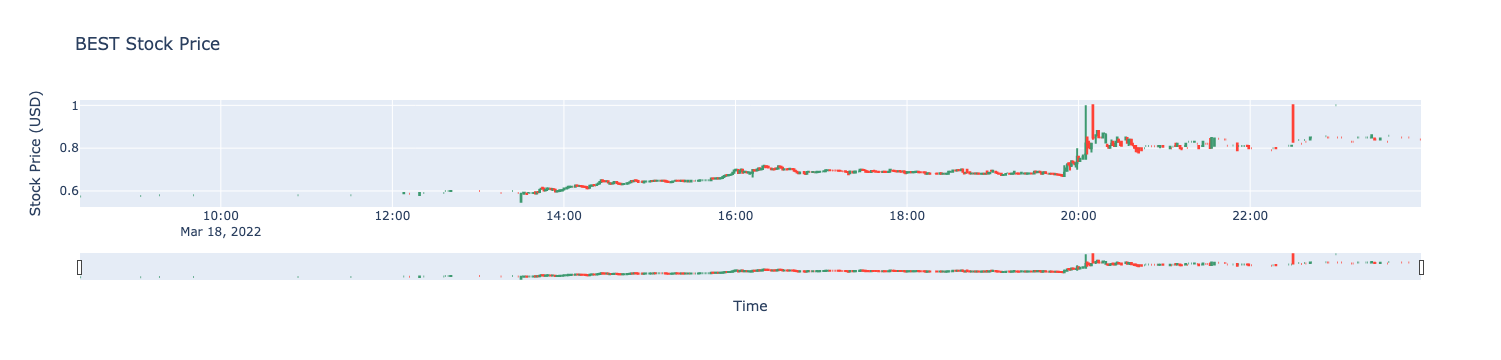

In [42]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [ ]:
# This was run including the TRF trades.  The notable difference is ignoring the the $1.0 trade reported at 21:05 but which took place earlier. The bars at 20:05, 20:10, and 22:30 seem related.
# https://polygon.io/blog/understanding-trade-eligibility

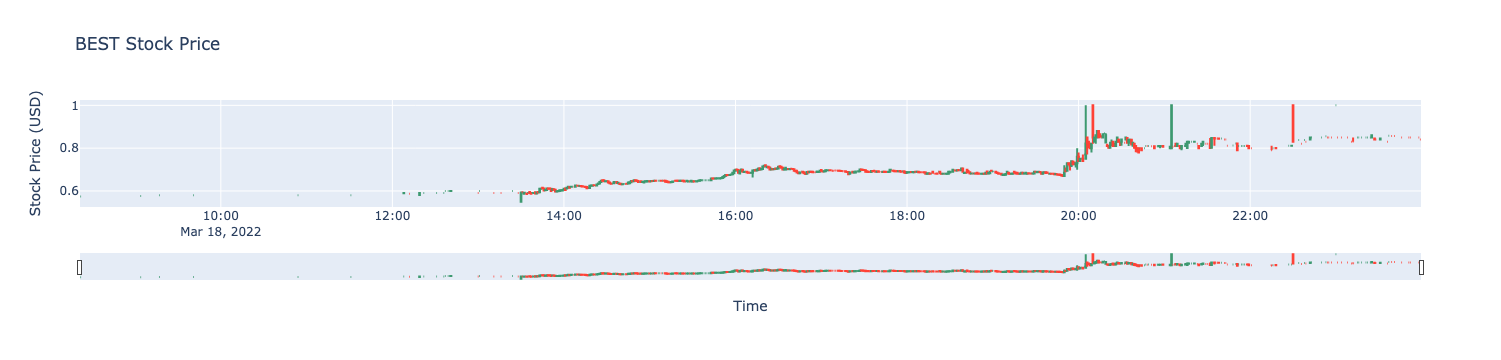

In [39]:
ticker = 'BEST'

best_df = aggs_df.loc[(ticker)]

# Create the candlestick chart
fig = go.Figure(data=[go.Candlestick(x=best_df.index,
                                     open=best_df['open'],
                                     high=best_df['high'],
                                     low=best_df['low'],
                                     close=best_df['close'],
                                     name='Stock Data')])

# Add titles and labels
fig.update_layout(title=f'{ticker} Stock Price',
                  yaxis_title='Stock Price (USD)',
                  xaxis_title='Time',
                  xaxis_rangeslider_visible=True)

# Show the figure
fig.show()

In [236]:
def label_ticker_session(df: pd.DataFrame, start: pd.Timestamp, end: pd.Timestamp):
    # df.info()
    df = df.loc[start:end]
    if len(df) < 1:
        return pd.DataFrame()
    # df.info()
    open_price = df.iloc[0]['open']
    session_index = pd.date_range(start=df.index[0],
                                  end=df.index[-1],
                                  freq=pd.Timedelta(seconds=60))
    df = df.reindex(session_index)
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=60)
    df['gain_from_open'] = ((df['open'] - open_price) / open_price) * 100
    df['fwd_1h_min_low'] = df.rolling(window=indexer, min_periods=1).low.min()
    df['fwd_1h_max_close'] = df.rolling(window=indexer, min_periods=1).close.max()
    next_close = df['close'].shift(-1)
    df['gain_1h'] = (((df['fwd_1h_max_close'] - next_close) / next_close) * 100)
    df['loss_1h'] = (((df['fwd_1h_min_low'] - next_close) / next_close) * 100)
    return df


def label_ticker_day_aggs(df: pd.DataFrame, schedule: pd.Series):
    pre_df = label_ticker_session(df, start=schedule['pre'], end=schedule['market_open'] - pd.Timedelta(seconds=60))
    market_df = label_ticker_session(df, start=schedule['market_open'], end=schedule['market_close'] - pd.Timedelta(seconds=60))
    post_df = label_ticker_session(df, start=schedule['market_close'], end=schedule['post'] - pd.Timedelta(seconds=60))
    return pd.concat([pre_df, market_df, post_df])


def label_custom_aggs_for_date(date, sessions, fragment):
    def label_custom_aggs(df: pd.DataFrame):
        # ticker = df.iloc[0]['ticker']
        # df = df.drop(columns=['ticker'])
        df = df.set_index('window_start').sort_index()
        # df = df.set_index('window_start')
        # df.info()
        df = label_ticker_day_aggs(df, sessions)
        # df['ticker'] = ticker
        return df
    
    aggs_table = fragment.to_table()
    aggs_df = aggs_table.to_pandas()
    aggs_df.set_index('ticker', inplace=True)
    aggs_df.sort_index(inplace=True)
    labeled_aggs_dfs = aggs_df.groupby('ticker').apply(label_custom_aggs)
    labeled_aggs_dfs.info()
    print(labeled_aggs_dfs)


def label_custom_aggs_ds(config: PolygonConfig):
    calendar = pandas_market_calendars.get_calendar(config.calendar_name)
    schedule = calendar.schedule(start_date=config.start_date,
                                 end_date=config.end_date,
                                 start="pre",
                                 end="post",
                                 tz='US/Eastern')
    for date, sessions in schedule.iterrows():
        print(f"{date=} {sessions=}")
        filter_expr = (pc.field('year') == date.year) & (pc.field('month') == date.month) & (pc.field('date') == date.to_pydatetime().date())
        print(f"{filter_expr=}")
        aggs_ds = pa_ds.dataset(config.custom_aggs_dir,
                                format="parquet",
                                schema=custom_aggs_schema(),
                                partitioning=custom_aggs_partitioning())
        for fragment in aggs_ds.get_fragments(filter=filter_expr):
            label_custom_aggs_for_date(date, sessions, fragment)

In [238]:
config.start_date = '2024-12-05'
config.end_date = '2024-12-05'
label_custom_aggs_ds(config)

date=Timestamp('2024-12-05 00:00:00') sessions=pre            2024-12-05 04:00:00-05:00
market_open    2024-12-05 09:30:00-05:00
market_close   2024-12-05 16:00:00-05:00
post           2024-12-05 20:00:00-05:00
Name: 2024-12-05 00:00:00, dtype: datetime64[ns, US/Eastern]
filter_expr=<pyarrow.compute.Expression (((year == 2024) and (month == 12)) and (date == 2024-12-05))>
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 6425354 entries, ('A', Timestamp('2024-12-05 09:32:00+0000', tz='UTC')) to ('ZZZ', Timestamp('2024-12-05 21:00:00+0000', tz='UTC'))
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   open              float64
 1   high              float64
 2   low               float64
 3   close             float64
 4   volume            float64
 5   transactions      float64
 6   gain_from_open    float64
 7   fwd_1h_min_low    float64
 8   fwd_1h_max_close  float64
 9   gain_1h           float64
 10  loss_1h           float64
dtypes: